This notebook calculates air-sea CO2 fluxes based on the pCO2 reconstructions using SOCAT + USV Saildrone sampling masks.

We calculate fluxes separately for reconstructions for each model in the LET (CESM, CanESM2 and GFDL) and then combine.

This notebook was created by Thea Hatlen Heimdal and Amanda Fay, in collaboration with Julius Busecke

In [1]:
import xarray as xr
import numpy as np
import pickle
import matplotlib.pyplot as plt
import cmocean as cm 
import math

### Water vapor correction function

In [3]:
def calc_pco2_from_xco2(xco2,pres,T,S):

# %test:
# % xco2=378.16;
# % pres=1018.02;
# % T=15;
# % S=35;
#in matlab I do this: atm_pco2_wvcorr = calc_pco2_from_xco2(xco2atm,pres_mb_1980_2019,SST,SSS); so this seems like pressure was in mb.
#1mb is the same as 1 hPa

# %calculate pressure at 100% humidity
    a1 = -7.85951783
    a2 = 1.84408259
    a4 = 22.6807411 
    a5 = -15.9618719
    a3 = -11.7866497
    a6 = 1.80122502

# %T=298.15;
    Tc = 647.096
    pc = 22064000
    # %S=35;
    T=T+273.15

    Phi=(1-(T/Tc))
    lnform=(Tc/T)*(a1*Phi+a2*Phi**(1.5)+a3*Phi**3+a4*Phi**(3.5)+a5*Phi**(4)+a6*Phi**(7.5))
    Psig=np.exp(lnform)*pc

    molarity=(31.998*S)/(10**3-1.005*S)
    Psi=0.90799-0.08992*(0.5*molarity)+0.18458*(0.5*molarity)**2-0.07395*(0.5*molarity)**3-0.00221*(0.5*molarity)**4
    Psigcor=Psig*np.exp(-0.018*Psi*molarity)

# %convert pressure from hPa to Pascal
    pres=pres*100

# %calculate pCO2 wet in Pa
    pco2_Pa= (xco2*10**-6)*(pres-Psigcor)

# %and convert into muatm
    pco2=pco2_Pa*9.8692326671601E-6*10**6

    return pco2

### <font color='orange'>CESM</font> 

For this model, we don't have pre-calculated pCO2 atm, so we have to calculate this. We will apply the water vapor correction to do so.  

#### Bring in ocean pCO2 and XCO2

In [4]:
dsm = xr.open_dataset('/data/artemis/simulations/LET/CESM/member_021/pCO2_2D_mon_CESM021_1x1_198201-201701.nc')
model = dsm.pCO2
#load in the xco2 from cesm
ds = xr.open_dataset('/data/artemis/simulations/LET/CESM/member_001/XCO2_1D_mon_CESM001_native_198201-201701.nc')
xco2 = ds.XCO2
del ds

#### Bring in ocean SSS, SST and air pressure

In [5]:
#want to calculate wv corr atm pco2
#get pressure
ds = xr.open_dataset('/data/artemis/simulations/LET/CESM/member_021/pATM_2D_mon_CESM021_1x1_198201-201701.nc')
pres = ds.pATM
#sst
ds = xr.open_dataset('/data/artemis/simulations/LET/CESM/member_021/SST_2D_mon_CESM021_1x1_198201-201701.nc')
sst = ds.SST
#sss
ds = xr.open_dataset('/data/artemis/simulations/LET/CESM/member_021/SSS_2D_mon_CESM021_1x1_198201-201701.nc')
sss = ds.SSS

In [6]:
#ensure they all have the same time

model['time'] = model.time.data.astype('datetime64[s]')  - np.timedelta64(1, 'D')
sst['time'] = model['time']
sss['time'] = model['time']
pres['time'] = model['time']
xco2['time'] = model['time']

#### Convert air pressure from atm to hPa

In [7]:
pres_hpa = pres*1013.25

#### Calculate pCO2 atm (corrected for water vapor)

In [8]:
cesm_calc_atm_wvcorr = calc_pco2_from_xco2(xco2,pres_hpa,sst,sss)

### Bring in CESM ocean pCO2 reconstructions and the model truth

In [2]:
path_LET = "/local/data/artemis/workspace/theimdal/saildrone/LET_pickle_files/members_LET_dict_CESM.pickle"

with open(path_LET,'rb') as handle:
    mems_dict = pickle.load(handle)

In [3]:
mems_dict

{'CESM': ['001',
  '002',
  '009',
  '010',
  '011',
  '012',
  '013',
  '014',
  '015',
  '016',
  '017',
  '018',
  '020',
  '021',
  '023',
  '024',
  '025',
  '030',
  '031',
  '034',
  '035',
  '101',
  '102',
  '103',
  '104']}

In [13]:
datasets_ens = []
for ens, mem_list in mems_dict.items():
    datasets_member = []
    for n_member, member in enumerate(mem_list):

        truth_path = f"/data/artemis/simulations/LET/{ens}/member_{member}/pCO2_2D_mon_{ens}{member}_1x1_198201-201701.nc"
        recon_path = f"/data/artemis/workspace/theimdal/SOCAT/models/reconstructions/xg/{ens}/member_{member}/recon_pCO2DIC_pCO2_2D_mon_{ens}_{member}_1x1_198201-201701.nc"
        #recon_path = f"/data/artemis/workspace/theimdal/saildrone_zigzag/models/5_years_x12_winter/reconstructions/xg/{ens}/member_{member}/recon_pCO2DIC_pCO2_2D_mon_{ens}_{member}_1x1_198201-201701.nc"
        kwargs = dict(chunks={'time':-1})
        
        truth = xr.open_dataset(truth_path, **kwargs).pCO2
        recon = xr.open_dataset(recon_path, **kwargs).pCO2_full_recon
        
        # assign_dimension coordinates
        truth = truth.assign_coords(status='truth')
        recon = recon.assign_coords(status='reconstructed')
        
        # make sure they have the same time coordinates
        truth = truth.assign_coords(time=recon['time'].data)
        
        member_ds = xr.concat([truth, recon], dim='status')
        
        # add member_dimension and coordinate
        member_ds = member_ds.assign_coords(n_member=n_member, member=member)
        
        datasets_member.append(member_ds)
    
    ds_ens = xr.concat(datasets_member, dim='n_member')
    ds_ens = ds_ens.assign_coords(ensemble=ens)
    
    
    datasets_ens.append(ds_ens)
    
ds_both = xr.concat(datasets_ens, dim='ensemble', join='override') 

In [14]:
#replace all 0 by nans
ds_both = ds_both.where(ds_both != 0.)

In [15]:
#rename pCO2 atm variable
CESM_pco2atm = cesm_calc_atm_wvcorr

In [16]:
### paths

seaflux_file = '/data/artemis/observations/SeaFlux/SeaFlux_v2022.01_no_pco2.nc'

ocean_area_file = '/data/artemis/observations/SOCOM/extra_files/SeaFlux_v2021.04_area_ocean.nc'

In [17]:
recon_ens = ds_both
recon_ens = recon_ens.sel(time=slice("1983-01-01","2016-12-31"))


CESM_pco2atm = CESM_pco2atm.sel(time=slice("1983-01-01","2016-12-31"))


start_yearmonth = str(recon_ens.time.min().data.astype('datetime64[s]').item().strftime('%Y-%m'))
end_yearmonth = str(recon_ens.time.max().data.astype('datetime64[s]').item().strftime('%Y-%m'))
print(f'{start_yearmonth} to {end_yearmonth}')

1983-01 to 2016-12


In [18]:
seaflux = xr.open_dataset(seaflux_file)

In [19]:
kw1 = seaflux.kw_cmhr.sel(wind=["ERA5"])
kw = kw1 * 87.6  # --> cm/hr now m/yr
kw = kw.where(kw > 0)  # solubility (mol/m3/uatm) and kw converted from (cm/hr) to (m/s)
                        #should always be over 0 so this prevents againsts issues in other releases
                        #update so that kw1 is nan if 0 ever (so mean is not too low)
k0 = seaflux.sol_molm3uatm#[1:,:,:] # mol / m3 / uatm
icef = seaflux.ice_frac # ice fraction 
ice_weighting = 1 - icef.fillna(0)
#atmos = seaflux.atm_pco2_uatm #uatm

In [20]:
#filter to same time frame
#atmos_filter = atmos.sel(time=slice(str(start_yearmonth),str(end_yearmonth))) 
k0_filter = k0.sel(time=slice(str(start_yearmonth),str(end_yearmonth))) 
kw_filter = kw.sel(time=slice(str(start_yearmonth),str(end_yearmonth))) 
ice_weighting_filter = ice_weighting.sel(time=slice(str(start_yearmonth),str(end_yearmonth))) 

In [21]:
#Now process reconstructed pco2
recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')  
recon_ens['time'] = k0_filter['time'] 

lon2 = np.where(recon_ens.xlon>180,recon_ens.xlon-360,recon_ens.xlon)
recon_ens['xlon'] = (lon2)
recon_ens = recon_ens.sortby(recon_ens.xlon)

if True: 
    pco2_ens = recon_ens.rename({'xlon': 'lon'})
    pco2_ens = pco2_ens.rename({'ylat': 'lat'})
    pco2_ens = pco2_ens.transpose('time','lat','lon',...)

spco2_ens = pco2_ens
#delta_ens = spco2_ens - atmos_filter
#delta_ens = spco2_ens - pco2atm2

/home/theimdal/.conda/envs/cesm_play/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [22]:
#Now process pco2 atm
CESM_pco2atm['time'] = CESM_pco2atm.time.data.astype('datetime64[s]')
CESM_pco2atm['time'] = recon_ens['time']

lon2 = np.where(CESM_pco2atm.xlon>180,CESM_pco2atm.xlon-360,CESM_pco2atm.xlon)
CESM_pco2atm['xlon'] = (lon2)
CESM_pco2atm = CESM_pco2atm.sortby(CESM_pco2atm.xlon)

if True: 
    pco2atm = CESM_pco2atm.rename({'xlon': 'lon'})
    pco2atm = pco2atm.rename({'ylat': 'lat'})
    pco2atm = pco2atm.transpose('time','lat','lon',...)

pco2atm2 = pco2atm

In [23]:
delta_ens = spco2_ens - pco2atm2

In [24]:
#calculate flux
flux_ens_CESM =(   k0_filter
            * kw_filter
            * delta_ens 
            * ice_weighting_filter
           ) # mol/m2/yr

In [25]:
# The "raw" LET output ("truth") has no areas masked out, but the reconstructions do.
# Here we remove flux calc for unmasked area for truth reconstruction for a fair comparison between
# the model truth and the reconstructions. 

flux_truth = flux_ens_CESM.sel(status="truth")
flux_recon = flux_ens_CESM.sel(status="reconstructed")

flux_truth_masked = xr.where(flux_recon.notnull(),flux_truth,-1000)
flux_truth_masked = flux_truth_masked.where(flux_truth_masked != -1000)

### Enhancing / Summarizing Flux

### Globally

#### Flux truth

In [26]:
sarea = xr.open_dataset(ocean_area_file)
area = sarea.area_ocean

flux_tmp_truth = flux_truth_masked * area *12     # g/yr flux_ens is in mol/m2/yr so *area gets you mol/yr and then *12 is g/yr
flux_tmp_truth = flux_tmp_truth
flux_region_ens_truth = flux_tmp_truth.sum(['lat','lon']) 
flux_ens_co2_truth = flux_region_ens_truth.where(flux_region_ens_truth!=0) #sum over the region to get total flux in Pg/yr
flux_ens_co2_truth.attrs['units'] = 'g/yr'

In [27]:
annual_fluxes_truth_CESM = flux_ens_co2_truth.groupby("time.year").mean("time")

#### Flux reconstructed

In [28]:
sarea = xr.open_dataset(ocean_area_file)
area = sarea.area_ocean

flux_tmp_recon = flux_recon * area *12     # g/yr flux_ens is in mol/m2/yr so *area gets you mol/yr and then *12 is g/yr
flux_tmp_recon = flux_tmp_recon
flux_region_ens_recon = flux_tmp_recon.sum(['lat','lon']) 
flux_ens_co2_recon = flux_region_ens_recon.where(flux_region_ens_recon!=0) #sum over the region to get total flux in Pg/yr
flux_ens_co2_recon.attrs['units'] = 'g/yr'

In [29]:
annual_fluxes_recon_CESM = flux_ens_co2_recon.groupby("time.year").mean("time")

### <font color='blue'>Southern Ocean</font> 

#### Flux Truth

In [30]:
sarea = xr.open_dataset(ocean_area_file)
area = sarea.area_ocean.sel(lat=slice(-90,-30))

flux_tmp_truth = flux_truth_masked * area *12     # g/yr flux_ens is in mol/m2/yr so *area gets you mol/yr and then *12 is g/yr
flux_tmp_truth = flux_tmp_truth.sel(lat=slice(-90,-30))
flux_region_ens_truth = flux_tmp_truth.sum(['lat','lon']) 
flux_ens_co2_truth = flux_region_ens_truth.where(flux_region_ens_truth!=0) #sum over the region to get total flux in Pg/yr
flux_ens_co2_truth.attrs['units'] = 'g/yr'

/home/theimdal/.conda/envs/cesm_play/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [31]:
annual_fluxes_truth_SO_CESM = flux_ens_co2_truth.groupby("time.year").mean("time")

#### Flux Reconstructed

In [32]:
sarea = xr.open_dataset(ocean_area_file)
area = sarea.area_ocean.sel(lat=slice(-90,-30))

flux_tmp_recon = flux_recon * area *12     # g/yr flux_ens is in mol/m2/yr so *area gets you mol/yr and then *12 is g/yr
flux_tmp_recon = flux_tmp_recon.sel(lat=slice(-90,-30))
flux_region_ens_recon = flux_tmp_recon.sum(['lat','lon']) 
flux_ens_co2_recon = flux_region_ens_recon.where(flux_region_ens_recon!=0) #sum over the region to get total flux in Pg/yr
flux_ens_co2_recon.attrs['units'] = 'g/yr'

/home/theimdal/.conda/envs/cesm_play/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [33]:
annual_fluxes_recon_SO_CESM = flux_ens_co2_recon.groupby("time.year").mean("time")

### <font color='purple'>GFDL</font> 

For this model, we have pre-calculated pCO2 atm. 

### Bring in pco2 atm for all 25 members of GFDL

In [4]:
path_LET = "/local/data/artemis/workspace/theimdal/saildrone/LET_pickle_files/members_LET_dict_GFDL.pickle" #without MPI

with open(path_LET,'rb') as handle:
    mems_dict = pickle.load(handle)

In [5]:
mems_dict

{'GFDL': ['01',
  '02',
  '03',
  '04',
  '05',
  '06',
  '08',
  '09',
  '10',
  '11',
  '12',
  '13',
  '14',
  '16',
  '17',
  '18',
  '19',
  '20',
  '22',
  '23',
  '26',
  '27',
  '28',
  '29',
  '30']}

In [37]:
datasets_ens = []
for ens, mem_list in mems_dict.items():
    datasets_member = []
    for n_member, member in enumerate(mem_list):

        truth_path = f"/data/artemis/simulations/LET/{ens}/member_{member}/pCO2ATM_2D_mon_{ens}{member}_1x1_198201-201701.nc"
        recon_path = f"/data/artemis/workspace/theimdal/SOCAT/models/reconstructions/xg/{ens}/member_{member}/recon_pCO2DIC_pCO2_2D_mon_{ens}_{member}_1x1_198201-201701.nc"
        kwargs = dict(chunks={'time':-1})
        
        truth = xr.open_dataset(truth_path, **kwargs).pCO2ATM
        recon = xr.open_dataset(recon_path, **kwargs).pCO2_full_recon
        
        # assign_dimension coordinates
        truth = truth.assign_coords(status='truth')
        recon = recon.assign_coords(status='reconstructed')
        
        # make sure they have the same time coordinates
        truth = truth.assign_coords(time=recon['time'].data)
        
        member_ds = xr.concat([truth, recon], dim='status')
        
        # add member_dimension and coordinate
        member_ds = member_ds.assign_coords(n_member=n_member, member=member)
        
        datasets_member.append(member_ds)
    
    ds_ens = xr.concat(datasets_member, dim='n_member')
    ds_ens = ds_ens.assign_coords(ensemble=ens)
    
    
    datasets_ens.append(ds_ens)
    
ds_GFDL = xr.concat(datasets_ens, dim='ensemble', join='override') 

#### Select pCO2 atm only

In [38]:
GFDL_pco2atm = ds_GFDL.sel(status="truth")

### Bring in GFDL ocean pCO2 reconstructions

In [39]:
datasets_ens = []
for ens, mem_list in mems_dict.items():
    datasets_member = []
    for n_member, member in enumerate(mem_list):

        truth_path = f"/data/artemis/simulations/LET/{ens}/member_{member}/pCO2_2D_mon_{ens}{member}_1x1_198201-201701.nc"
        recon_path = f"/data/artemis/workspace/theimdal/SOCAT/models/reconstructions/xg/{ens}/member_{member}/recon_pCO2DIC_pCO2_2D_mon_{ens}_{member}_1x1_198201-201701.nc"
        #recon_path = f"/data/artemis/workspace/theimdal/saildrone_zigzag/models/5_years_x12_winter/reconstructions/xg/{ens}/member_{member}/recon_pCO2DIC_pCO2_2D_mon_{ens}_{member}_1x1_198201-201701.nc"
        kwargs = dict(chunks={'time':-1})
        
        truth = xr.open_dataset(truth_path, **kwargs).pCO2
        recon = xr.open_dataset(recon_path, **kwargs).pCO2_full_recon
        
        # assign_dimension coordinates
        truth = truth.assign_coords(status='truth')
        recon = recon.assign_coords(status='reconstructed')
        
        # make sure they have the same time coordinates
        truth = truth.assign_coords(time=recon['time'].data)
        
        member_ds = xr.concat([truth, recon], dim='status')
        
        # add member_dimension and coordinate
        member_ds = member_ds.assign_coords(n_member=n_member, member=member)
        
        datasets_member.append(member_ds)
    
    ds_ens = xr.concat(datasets_member, dim='n_member')
    ds_ens = ds_ens.assign_coords(ensemble=ens)
    
    
    datasets_ens.append(ds_ens)
    
ds_both = xr.concat(datasets_ens, dim='ensemble', join='override') 

In [40]:
#replace all 0 by nans
ds_both = ds_both.where(ds_both != 0.)

In [41]:
recon_ens = ds_both
recon_ens = recon_ens.sel(time=slice("1983-01-01","2016-12-31"))


GFDL_pco2atm = GFDL_pco2atm.sel(time=slice("1983-01-01","2016-12-31"))


start_yearmonth = str(recon_ens.time.min().data.astype('datetime64[s]').item().strftime('%Y-%m'))
end_yearmonth = str(recon_ens.time.max().data.astype('datetime64[s]').item().strftime('%Y-%m'))
print(f'{start_yearmonth} to {end_yearmonth}')

1983-01 to 2016-12


In [42]:
kw1 = seaflux.kw_cmhr.sel(wind=["ERA5"])
kw = kw1 * 87.6  # --> cm/hr now m/yr
kw = kw.where(kw > 0)  # solubility (mol/m3/uatm) and kw converted from (cm/hr) to (m/s)
                        #should always be over 0 so this prevents againsts issues in other releases
                        #update so that kw1 is nan if 0 ever (so mean is not too low)
k0 = seaflux.sol_molm3uatm#[1:,:,:] # mol / m3 / uatm
icef = seaflux.ice_frac # ice fraction 
ice_weighting = 1 - icef.fillna(0)
#atmos = seaflux.atm_pco2_uatm #uatm

In [43]:
#filter to same time frame
#atmos_filter = atmos.sel(time=slice(str(start_yearmonth),str(end_yearmonth))) 
k0_filter = k0.sel(time=slice(str(start_yearmonth),str(end_yearmonth))) 
kw_filter = kw.sel(time=slice(str(start_yearmonth),str(end_yearmonth))) 
ice_weighting_filter = ice_weighting.sel(time=slice(str(start_yearmonth),str(end_yearmonth))) 

In [44]:
#Now process reconstructed pco2
recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')  
recon_ens['time'] = k0_filter['time'] 

lon2 = np.where(recon_ens.xlon>180,recon_ens.xlon-360,recon_ens.xlon)
recon_ens['xlon'] = (lon2)
recon_ens = recon_ens.sortby(recon_ens.xlon)

if True: 
    pco2_ens = recon_ens.rename({'xlon': 'lon'})
    pco2_ens = pco2_ens.rename({'ylat': 'lat'})
    pco2_ens = pco2_ens.transpose('time','lat','lon',...)

spco2_ens = pco2_ens
#delta_ens = spco2_ens - atmos_filter
#delta_ens = spco2_ens - pco2atm2

/home/theimdal/.conda/envs/cesm_play/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [45]:
#Now process pco2 atm
GFDL_pco2atm['time'] = GFDL_pco2atm.time.data.astype('datetime64[s]')
GFDL_pco2atm['time'] = recon_ens['time']

lon2 = np.where(GFDL_pco2atm.xlon>180,GFDL_pco2atm.xlon-360,GFDL_pco2atm.xlon)
GFDL_pco2atm['xlon'] = (lon2)
GFDL_pco2atm = GFDL_pco2atm.sortby(GFDL_pco2atm.xlon)

if True: 
    pco2atm = GFDL_pco2atm.rename({'xlon': 'lon'})
    pco2atm = pco2atm.rename({'ylat': 'lat'})
    pco2atm = pco2atm.transpose('time','lat','lon',...)

pco2atm2 = pco2atm

/home/theimdal/.conda/envs/cesm_play/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [46]:
delta_ens = spco2_ens - pco2atm2

In [47]:
#calculate flux
flux_ens_GFDL =(   k0_filter
            * kw_filter
            * delta_ens 
            * ice_weighting_filter
           ) # mol/m2/yr

In [48]:
#remove flux calc for unmasked area for truth reconstruction 

flux_truth = flux_ens_GFDL.sel(status="truth")
flux_recon = flux_ens_GFDL.sel(status="reconstructed")

flux_truth_masked = xr.where(flux_recon.notnull(),flux_truth,-1000)
flux_truth_masked = flux_truth_masked.where(flux_truth_masked != -1000)

### Enhancing / Summarizing Flux

### Globally

#### Flux truth

In [49]:
sarea = xr.open_dataset(ocean_area_file)
area = sarea.area_ocean

flux_tmp_truth = flux_truth_masked * area *12     # g/yr flux_ens is in mol/m2/yr so *area gets you mol/yr and then *12 is g/yr
flux_tmp_truth = flux_tmp_truth
flux_region_ens_truth = flux_tmp_truth.sum(['lat','lon']) 
flux_ens_co2_truth = flux_region_ens_truth.where(flux_region_ens_truth!=0) #sum over the region to get total flux in Pg/yr
flux_ens_co2_truth.attrs['units'] = 'g/yr'

In [50]:
annual_fluxes_truth_GFDL = flux_ens_co2_truth.groupby("time.year").mean("time")

#### Flux reconstructed

In [51]:
sarea = xr.open_dataset(ocean_area_file)
area = sarea.area_ocean

flux_tmp_recon = flux_recon * area *12     # g/yr flux_ens is in mol/m2/yr so *area gets you mol/yr and then *12 is g/yr
flux_tmp_recon = flux_tmp_recon
flux_region_ens_recon = flux_tmp_recon.sum(['lat','lon']) 
flux_ens_co2_recon = flux_region_ens_recon.where(flux_region_ens_recon!=0) #sum over the region to get total flux in Pg/yr
flux_ens_co2_recon.attrs['units'] = 'g/yr'

In [52]:
annual_fluxes_recon_GFDL = flux_ens_co2_recon.groupby("time.year").mean("time")

### <font color='blue'>Southern Ocean</font> 

#### Flux Truth

In [53]:
sarea = xr.open_dataset(ocean_area_file)
area = sarea.area_ocean.sel(lat=slice(-90,-30))

flux_tmp_truth = flux_truth_masked * area *12     # g/yr flux_ens is in mol/m2/yr so *area gets you mol/yr and then *12 is g/yr
flux_tmp_truth = flux_tmp_truth.sel(lat=slice(-90,-30))
flux_region_ens_truth = flux_tmp_truth.sum(['lat','lon']) 
flux_ens_co2_truth = flux_region_ens_truth.where(flux_region_ens_truth!=0) #sum over the region to get total flux in Pg/yr
flux_ens_co2_truth.attrs['units'] = 'g/yr'

/home/theimdal/.conda/envs/cesm_play/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [54]:
annual_fluxes_truth_SO_GFDL = flux_ens_co2_truth.groupby("time.year").mean("time")

#### Flux Reconstructed

In [55]:
sarea = xr.open_dataset(ocean_area_file)
area = sarea.area_ocean.sel(lat=slice(-90,-30))

flux_tmp_recon = flux_recon * area *12     # g/yr flux_ens is in mol/m2/yr so *area gets you mol/yr and then *12 is g/yr
flux_tmp_recon = flux_tmp_recon.sel(lat=slice(-90,-30))
flux_region_ens_recon = flux_tmp_recon.sum(['lat','lon']) 
flux_ens_co2_recon = flux_region_ens_recon.where(flux_region_ens_recon!=0) #sum over the region to get total flux in Pg/yr
flux_ens_co2_recon.attrs['units'] = 'g/yr'

/home/theimdal/.conda/envs/cesm_play/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [56]:
annual_fluxes_recon_SO_GFDL = flux_ens_co2_recon.groupby("time.year").mean("time")

### <font color='orange'>CanESM2</font> 

For this model, we don't have pre-calculated pCO2 atm, so we have to calculate this. We do not apply the water vapor correction. 

#### Bring in ocean pCO2 and XCO2

In [57]:
dsmc = xr.open_dataset('/data/artemis/simulations/LET/CanESM2/member_r1r9/pCO2_2D_mon_CanESM2r1r9_1x1_198201-201712.nc')
modelc = dsmc.pCO2

#load in the xco2 from cesm
ds = xr.open_dataset('/data/artemis/simulations/LET/CESM/member_001/XCO2_1D_mon_CESM001_native_198201-201701.nc')
xco2 = ds.XCO2
del ds

In [58]:
#want to calculate wv corr atm pco2
#get pressure
ds = xr.open_dataset('/data/artemis/simulations/LET/CanESM2/member_r1r9/pATM_2D_mon_CanESM2r1r9_1x1_198201-201712.nc')
pres = ds.pATM
#sst
ds = xr.open_dataset('/data/artemis/simulations/LET/CanESM2/member_r1r9/SST_2D_mon_CanESM2r1r9_1x1_198201-201712.nc')
sst = ds.SST
#sss
ds = xr.open_dataset('/data/artemis/simulations/LET/CanESM2/member_r1r9/SSS_2D_mon_CanESM2r1r9_1x1_198201-201712.nc')
sss = ds.SSS

In [59]:
#ensure they all have the same time

modelc['time'] = modelc.time.data.astype('datetime64[s]')  + np.timedelta64(14, 'D')
sst['time'] = modelc['time']
sss['time'] = modelc['time']
pres['time'] = modelc['time']
xco2['time'] = modelc['time']

In [60]:
pres_hpa = pres*1013.25

#### Calculate pCO2 atm (NOT corrected for water vapor)

In [61]:
#do just pres *xco2
can_atm_nocorr = pres*xco2

In [62]:
#this is just to bring in nans over land
can_calc_atm_wvcorr = calc_pco2_from_xco2(xco2,pres_hpa,sst,sss)

#### Make nans over land for non-corrected pCO2 atm

In [63]:
can_atm_nocorr = can_atm_nocorr.where(can_calc_atm_wvcorr.notnull(), -1000)
can_atm_nocorr = can_atm_nocorr.where(can_atm_nocorr != -1000) #make -1000s nans

In [64]:
dsm = xr.open_dataset('/data/artemis/simulations/LET/CESM/member_021/pCO2_2D_mon_CESM021_1x1_198201-201701.nc')
model = dsm.pCO2

In [65]:
#ensure they have the same time
modelc['time'] = model['time']

In [66]:
#ocean pCO2
#have to fill in mask for modelc or else really low mean values
modelc = modelc.where(model.notnull(), -1000)
modelc = modelc.where(modelc != -1000) #make -1000s nans
modelc = modelc.where(modelc != 0.)

### Bring in CESM ocean pCO2 reconstructions

In [6]:
path_LET = "/local/data/artemis/workspace/theimdal/saildrone/LET_pickle_files/members_LET_dict_CanESM2.pickle" #without MPI

with open(path_LET,'rb') as handle:
    mems_dict = pickle.load(handle)

In [7]:
mems_dict

{'CanESM2': ['r1r10',
  'r1r9',
  'r3r1',
  'r4r5',
  'r5r10',
  'r2r1',
  'r3r2',
  'r3r9',
  'r4r6',
  'r5r2',
  'r1r6',
  'r2r2',
  'r3r4',
  'r4r1',
  'r4r7',
  'r5r4',
  'r1r7',
  'r3r6',
  'r4r8',
  'r5r5',
  'r2r8',
  'r3r7',
  'r4r3',
  'r5r1',
  'r5r9']}

In [68]:
datasets_ens = []
for ens, mem_list in mems_dict.items():
    datasets_member = []
    for n_member, member in enumerate(mem_list):

        truth_path = f"/data/artemis/simulations/LET/{ens}/member_{member}/pCO2_2D_mon_{ens}{member}_1x1_198201-201712.nc"
        recon_path = f"/data/artemis/workspace/theimdal/SOCAT/models/reconstructions/xg/{ens}/member_{member}/recon_pCO2DIC_pCO2_2D_mon_{ens}_{member}_1x1_198201-201701.nc"
        #recon_path = f"/data/artemis/workspace/theimdal/saildrone_zigzag/models/5_years_x12_winter/reconstructions/xg/{ens}/member_{member}/recon_pCO2DIC_pCO2_2D_mon_{ens}_{member}_1x1_198201-201701.nc"
        kwargs = dict(chunks={'time':-1})
        
        truth = xr.open_dataset(truth_path, **kwargs).pCO2
        recon = xr.open_dataset(recon_path, **kwargs).pCO2_full_recon
        
        # assign_dimension coordinates
        truth = truth.assign_coords(status='truth')
        recon = recon.assign_coords(status='reconstructed')
        
        # make sure they have the same time coordinates
        truth = truth.assign_coords(time=recon['time'].data)
        
        member_ds = xr.concat([truth, recon], dim='status')
        
        # add member_dimension and coordinate
        member_ds = member_ds.assign_coords(n_member=n_member, member=member)
        
        datasets_member.append(member_ds)
    
    ds_ens = xr.concat(datasets_member, dim='n_member')
    ds_ens = ds_ens.assign_coords(ensemble=ens)
    
    
    datasets_ens.append(ds_ens)
    
ds_both = xr.concat(datasets_ens, dim='ensemble', join='override') 

In [69]:
#replace all 0 by nans
ds_both = ds_both.where(ds_both != 0.)

In [70]:
#rename pCO2 atm variable
CanESM2_pco2atm = can_atm_nocorr

In [71]:
recon_ens = ds_both
recon_ens = recon_ens.sel(time=slice("1983-01-01","2016-12-31"))


CanESM2_pco2atm = CanESM2_pco2atm.sel(time=slice("1983-01-01","2016-12-31"))


start_yearmonth = str(recon_ens.time.min().data.astype('datetime64[s]').item().strftime('%Y-%m'))
end_yearmonth = str(recon_ens.time.max().data.astype('datetime64[s]').item().strftime('%Y-%m'))
print(f'{start_yearmonth} to {end_yearmonth}')

1983-01 to 2016-12


In [72]:
kw1 = seaflux.kw_cmhr.sel(wind=["ERA5"])
kw = kw1 * 87.6  # --> cm/hr now m/yr
kw = kw.where(kw > 0)  # solubility (mol/m3/uatm) and kw converted from (cm/hr) to (m/s)
                        #should always be over 0 so this prevents againsts issues in other releases
                        #update so that kw1 is nan if 0 ever (so mean is not too low)
k0 = seaflux.sol_molm3uatm#[1:,:,:] # mol / m3 / uatm
icef = seaflux.ice_frac # ice fraction 
ice_weighting = 1 - icef.fillna(0)
#atmos = seaflux.atm_pco2_uatm #uatm

In [73]:
#filter to same time frame
#atmos_filter = atmos.sel(time=slice(str(start_yearmonth),str(end_yearmonth))) 
k0_filter = k0.sel(time=slice(str(start_yearmonth),str(end_yearmonth))) 
kw_filter = kw.sel(time=slice(str(start_yearmonth),str(end_yearmonth))) 
ice_weighting_filter = ice_weighting.sel(time=slice(str(start_yearmonth),str(end_yearmonth))) 

In [74]:
#Now process reconstructed pco2
recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')  
recon_ens['time'] = k0_filter['time'] 

lon2 = np.where(recon_ens.xlon>180,recon_ens.xlon-360,recon_ens.xlon)
recon_ens['xlon'] = (lon2)
recon_ens = recon_ens.sortby(recon_ens.xlon)

if True: 
    pco2_ens = recon_ens.rename({'xlon': 'lon'})
    pco2_ens = pco2_ens.rename({'ylat': 'lat'})
    pco2_ens = pco2_ens.transpose('time','lat','lon',...)

spco2_ens = pco2_ens
#delta_ens = spco2_ens - atmos_filter
#delta_ens = spco2_ens - pco2atm2

/home/theimdal/.conda/envs/cesm_play/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [75]:
#Now process pco2 atm
CanESM2_pco2atm['time'] = CanESM2_pco2atm.time.data.astype('datetime64[s]')
CanESM2_pco2atm['time'] = recon_ens['time']

lon2 = np.where(CanESM2_pco2atm.xlon>180,CanESM2_pco2atm.xlon-360,CanESM2_pco2atm.xlon)
CanESM2_pco2atm['xlon'] = (lon2)
CanESM2_pco2atm = CanESM2_pco2atm.sortby(CanESM2_pco2atm.xlon)

if True: 
    pco2atm = CanESM2_pco2atm.rename({'xlon': 'lon'})
    pco2atm = pco2atm.rename({'ylat': 'lat'})
    pco2atm = pco2atm.transpose('time','lat','lon',...)

pco2atm2 = pco2atm

In [76]:
delta_ens = spco2_ens - pco2atm2

In [77]:
#calculate flux
flux_ens_CanESM2 =(   k0_filter
            * kw_filter
            * delta_ens 
            * ice_weighting_filter
           ) # mol/m2/yr

In [78]:
#remove flux calc for unmasked area for truth reconstruction 

flux_truth = flux_ens_CanESM2.sel(status="truth")
flux_recon = flux_ens_CanESM2.sel(status="reconstructed")

flux_truth_masked = xr.where(flux_recon.notnull(),flux_truth,-1000)
flux_truth_masked = flux_truth_masked.where(flux_truth_masked != -1000)

In [79]:
sarea = xr.open_dataset(ocean_area_file)
area = sarea.area_ocean

flux_tmp_truth = flux_truth_masked * area *12     # g/yr flux_ens is in mol/m2/yr so *area gets you mol/yr and then *12 is g/yr
flux_tmp_truth = flux_tmp_truth
flux_region_ens_truth = flux_tmp_truth.sum(['lat','lon']) 
flux_ens_co2_truth = flux_region_ens_truth.where(flux_region_ens_truth!=0) #sum over the region to get total flux in Pg/yr
flux_ens_co2_truth.attrs['units'] = 'g/yr'

In [80]:
annual_fluxes_truth_CanESM2 = flux_ens_co2_truth.groupby("time.year").mean("time")

In [81]:
sarea = xr.open_dataset(ocean_area_file)
area = sarea.area_ocean

flux_tmp_recon = flux_recon * area *12     # g/yr flux_ens is in mol/m2/yr so *area gets you mol/yr and then *12 is g/yr
flux_tmp_recon = flux_tmp_recon
flux_region_ens_recon = flux_tmp_recon.sum(['lat','lon']) 
flux_ens_co2_recon = flux_region_ens_recon.where(flux_region_ens_recon!=0) #sum over the region to get total flux in Pg/yr
flux_ens_co2_recon.attrs['units'] = 'g/yr'

In [82]:
annual_fluxes_recon_CanESM2 = flux_ens_co2_recon.groupby("time.year").mean("time")

In [83]:
sarea = xr.open_dataset(ocean_area_file)
area = sarea.area_ocean.sel(lat=slice(-90,-30))

flux_tmp_truth = flux_truth_masked * area *12     # g/yr flux_ens is in mol/m2/yr so *area gets you mol/yr and then *12 is g/yr
flux_tmp_truth = flux_tmp_truth.sel(lat=slice(-90,-30))
flux_region_ens_truth = flux_tmp_truth.sum(['lat','lon']) 
flux_ens_co2_truth = flux_region_ens_truth.where(flux_region_ens_truth!=0) #sum over the region to get total flux in Pg/yr
flux_ens_co2_truth.attrs['units'] = 'g/yr'

/home/theimdal/.conda/envs/cesm_play/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [84]:
annual_fluxes_truth_SO_CanESM2 = flux_ens_co2_truth.groupby("time.year").mean("time")

In [85]:
sarea = xr.open_dataset(ocean_area_file)
area = sarea.area_ocean.sel(lat=slice(-90,-30))

flux_tmp_recon = flux_recon * area *12     # g/yr flux_ens is in mol/m2/yr so *area gets you mol/yr and then *12 is g/yr
flux_tmp_recon = flux_tmp_recon.sel(lat=slice(-90,-30))
flux_region_ens_recon = flux_tmp_recon.sum(['lat','lon']) 
flux_ens_co2_recon = flux_region_ens_recon.where(flux_region_ens_recon!=0) #sum over the region to get total flux in Pg/yr
flux_ens_co2_recon.attrs['units'] = 'g/yr'

/home/theimdal/.conda/envs/cesm_play/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [86]:
annual_fluxes_recon_SO_CanESM2 = flux_ens_co2_recon.groupby("time.year").mean("time")

### Merge flux from the three models

### Global

In [87]:
flux_truth_all_global = xr.concat([annual_fluxes_truth_GFDL, annual_fluxes_truth_CESM, annual_fluxes_truth_CanESM2], dim='model')

/home/theimdal/.conda/envs/cesm_play/lib/python3.8/site-packages/dask/array/core.py:4293: PerformanceWarning: Increasing number of chunks by factor of 25
  result = blockwise(
/home/theimdal/.conda/envs/cesm_play/lib/python3.8/site-packages/dask/array/core.py:4293: PerformanceWarning: Increasing number of chunks by factor of 25
  result = blockwise(
/home/theimdal/.conda/envs/cesm_play/lib/python3.8/site-packages/dask/array/core.py:4293: PerformanceWarning: Increasing number of chunks by factor of 25
  result = blockwise(


In [88]:
flux_truth_all_global_timeline = flux_truth_all_global.mean(["model", "n_member", "ensemble", "wind"])

In [89]:
flux_recon_all_global = xr.concat([annual_fluxes_recon_GFDL, annual_fluxes_recon_CESM, annual_fluxes_recon_CanESM2], dim='model')

/home/theimdal/.conda/envs/cesm_play/lib/python3.8/site-packages/dask/array/core.py:4293: PerformanceWarning: Increasing number of chunks by factor of 25
  result = blockwise(
/home/theimdal/.conda/envs/cesm_play/lib/python3.8/site-packages/dask/array/core.py:4293: PerformanceWarning: Increasing number of chunks by factor of 25
  result = blockwise(
/home/theimdal/.conda/envs/cesm_play/lib/python3.8/site-packages/dask/array/core.py:4293: PerformanceWarning: Increasing number of chunks by factor of 25
  result = blockwise(


In [90]:
flux_recon_all_global_timeline = flux_recon_all_global.mean(["model", "n_member", "ensemble", "wind"])

### Southern Ocean

In [91]:
flux_truth_all_SO = xr.concat([annual_fluxes_truth_SO_GFDL, annual_fluxes_truth_SO_CESM, annual_fluxes_truth_SO_CanESM2], dim='model')

/home/theimdal/.conda/envs/cesm_play/lib/python3.8/site-packages/dask/array/core.py:4293: PerformanceWarning: Increasing number of chunks by factor of 25
  result = blockwise(
/home/theimdal/.conda/envs/cesm_play/lib/python3.8/site-packages/dask/array/core.py:4293: PerformanceWarning: Increasing number of chunks by factor of 25
  result = blockwise(
/home/theimdal/.conda/envs/cesm_play/lib/python3.8/site-packages/dask/array/core.py:4293: PerformanceWarning: Increasing number of chunks by factor of 25
  result = blockwise(


In [92]:
flux_truth_all_SO_timeline = flux_truth_all_SO.mean(["model", "n_member", "ensemble", "wind"])

In [93]:
flux_recon_all_SO = xr.concat([annual_fluxes_recon_SO_GFDL, annual_fluxes_recon_SO_CESM, annual_fluxes_recon_SO_CanESM2], dim='model')

/home/theimdal/.conda/envs/cesm_play/lib/python3.8/site-packages/dask/array/core.py:4293: PerformanceWarning: Increasing number of chunks by factor of 25
  result = blockwise(
/home/theimdal/.conda/envs/cesm_play/lib/python3.8/site-packages/dask/array/core.py:4293: PerformanceWarning: Increasing number of chunks by factor of 25
  result = blockwise(
/home/theimdal/.conda/envs/cesm_play/lib/python3.8/site-packages/dask/array/core.py:4293: PerformanceWarning: Increasing number of chunks by factor of 25
  result = blockwise(


In [94]:
flux_recon_all_SO_timeline = flux_recon_all_SO.mean(["model", "n_member", "ensemble", "wind"])

### Calculate mean flux

### <font color='red'>Globally</font> 

In [95]:
flux_truth_global = flux_truth_all_global.sel(year=slice("1983-01-01","2016-12-31"))
print(np.nanmean(flux_truth_global)/(1e15))

In [96]:
flux_recon_global = flux_recon_all_global .sel(year=slice("1983-01-01","2016-12-31"))
print(np.nanmean(flux_recon_global)/(1e15))

### <font color='blue'>Southern Ocean</font> 

In [97]:
flux_truth_SO = flux_truth_all_SO.sel(year=slice("1983-01-01","2016-12-31"))
print(np.nanmean(flux_truth_SO)/(1e15))

In [98]:
flux_recon_SO = flux_recon_all_SO.sel(year=slice("1983-01-01","2016-12-31"))
print(np.nanmean(flux_recon_SO)/(1e15))

### Timeseries plots

#### <font color='red'>Globally</font> 

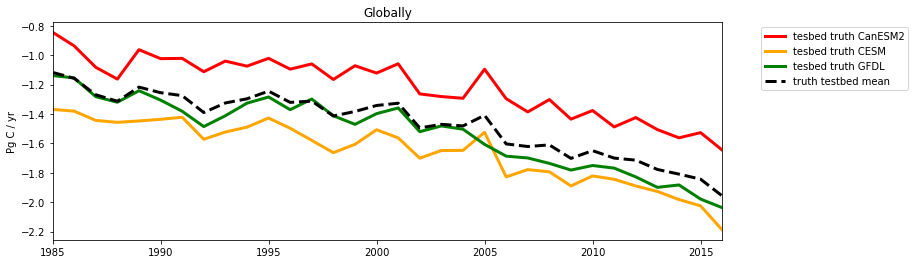

In [106]:
fig = plt.subplots(1,1,figsize=(12,4))

plt.plot(range(1983,2017),annual_fluxes_truth_CanESM2.mean(["wind", "n_member"])/(1e15),linewidth=3, label='tesbed truth CanESM2', color='red')
plt.plot(range(1983,2017),annual_fluxes_truth_CESM.mean(["wind", "n_member"])/(1e15),linewidth=3, label='tesbed truth CESM', color='orange')
plt.plot(range(1983,2017),annual_fluxes_truth_GFDL.mean(["wind", "n_member"])/(1e15),linewidth=3, label='tesbed truth GFDL', color='green')
plt.plot(range(1983,2017),flux_truth_all_global_timeline/(1e15),linewidth=3, label='testbed truth mean', color='black', linestyle='--')
#plt.plot(range(1983,2017),flux_recon_all_global_timeline/(1e15),linewidth=3, label='recon all', color='blue', linestyle='--')


# plt.grid(True)
plt.title(f"Globally")
plt.legend()
plt.ylabel('Pg C / yr')
#plt.ylim(-5,-1)
plt.xlim(1985,2016)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left');

#fig.savefig("/home/theimdal/fluxes.jpg",dpi=300)

#### <font color='blue'>Southern Ocean</font> 

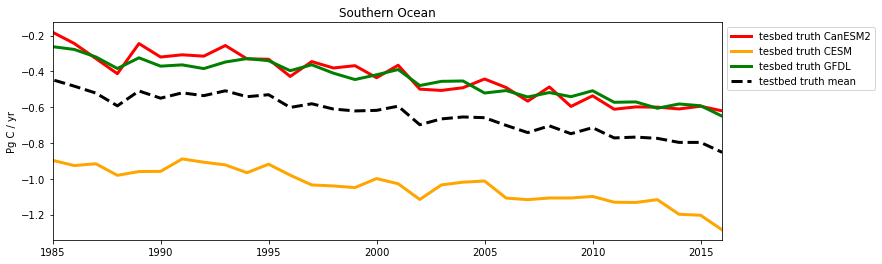

In [107]:
fig = plt.subplots(1,1,figsize=(12,4))

plt.plot(range(1983,2017),annual_fluxes_truth_SO_CanESM2.mean(["wind", "n_member"])/(1e15),linewidth=3, label='tesbed truth CanESM2', color='red')
plt.plot(range(1983,2017),annual_fluxes_truth_SO_CESM.mean(["wind", "n_member"])/(1e15),linewidth=3, label='tesbed truth CESM', color='orange')
plt.plot(range(1983,2017),annual_fluxes_truth_SO_GFDL.mean(["wind", "n_member"])/(1e15),linewidth=3, label='tesbed truth GFDL', color='green')
plt.plot(range(1983,2017),flux_truth_all_SO_timeline/(1e15),linewidth=3, label='testbed truth mean', color='black', linestyle='--')


# plt.grid(True)
plt.title(f"Southern Ocean")
plt.legend()
plt.ylabel('Pg C / yr')
#plt.ylim(-0.7,0.1)
plt.xlim(1985,2016)
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left');

#plt.savefig("pCO2Resid_Flux_DataProducts_Flux_1985-2019.eps",format="eps",dpi=1200)

### CESM only

(1985.0, 2016.0)

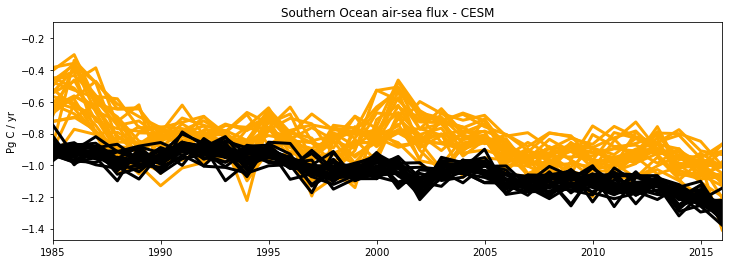

In [100]:
fig = plt.subplots(1,1,figsize=(12,4))


plt.plot(range(1983,2017),annual_fluxes_recon_SO_CESM.mean(["wind", "ensemble"])/(1e15),linewidth=3, label='recon CESM', color='orange')
plt.plot(range(1983,2017),annual_fluxes_truth_SO_CESM.mean(["wind", "ensemble"])/(1e15),linewidth=3, label='truth CESM', color='black')

# plt.grid(True)
plt.title(f"Southern Ocean air-sea flux - CESM")
#plt.legend()
plt.ylabel('Pg C / yr')
#plt.ylim(-0.7,0.1)
plt.xlim(1985,2016)
#plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left');

#plt.savefig("pCO2Resid_Flux_DataProducts_Flux_1985-2019.eps",format="eps",dpi=1200)

### CanESM2 only

(1985.0, 2016.0)

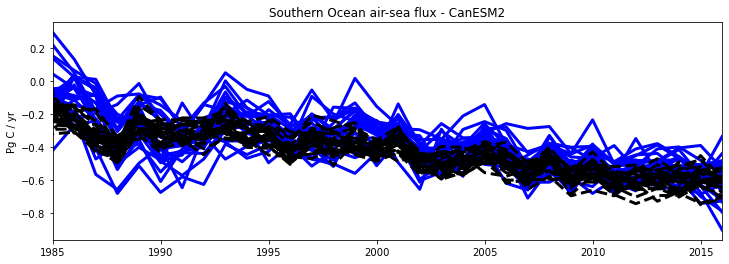

In [101]:
fig = plt.subplots(1,1,figsize=(12,4))


plt.plot(range(1983,2017),annual_fluxes_recon_SO_CanESM2.mean(["wind", "ensemble"])/(1e15),linewidth=3, label='recon CanCESM2', color='blue')
plt.plot(range(1983,2017),annual_fluxes_truth_SO_CanESM2.mean(["wind", "ensemble"])/(1e15),linewidth=3, label='mean truth CanCESM2', color='black', linestyle='--')

# plt.grid(True)
plt.title(f"Southern Ocean air-sea flux - CanESM2")
#plt.legend()
plt.ylabel('Pg C / yr')
#plt.ylim(-0.7,0.1)
plt.xlim(1985,2016)
#plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left');

#plt.savefig("pCO2Resid_Flux_DataProducts_Flux_1985-2019.eps",format="eps",dpi=1200)

### GFDL only

(1985.0, 2016.0)

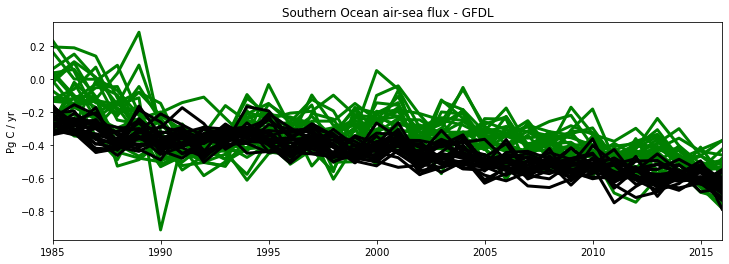

In [102]:
fig = plt.subplots(1,1,figsize=(12,4))


plt.plot(range(1983,2017),annual_fluxes_recon_SO_GFDL.mean(["wind", "ensemble"])/(1e15),linewidth=3, label='recon GFDL', color='green')
plt.plot(range(1983,2017),annual_fluxes_truth_SO_GFDL.mean(["wind", "ensemble"])/(1e15),linewidth=3, label='mean truth GFDL', color='black')
#plt.plot(range(1983,2017),flux_truth_all_SO_timeline/(1e15),linewidth=3, label='mean truth testbed', color='red', linestyle='--')

# plt.grid(True)
plt.title(f"Southern Ocean air-sea flux - GFDL")
#plt.legend()
plt.ylabel('Pg C / yr')
#plt.ylim(-0.7,0.1)
plt.xlim(1985,2016)
#plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left');

#plt.savefig("pCO2Resid_Flux_DataProducts_Flux_1985-2019.eps",format="eps",dpi=1200)

### Compare the three models

(1985.0, 2016.0)

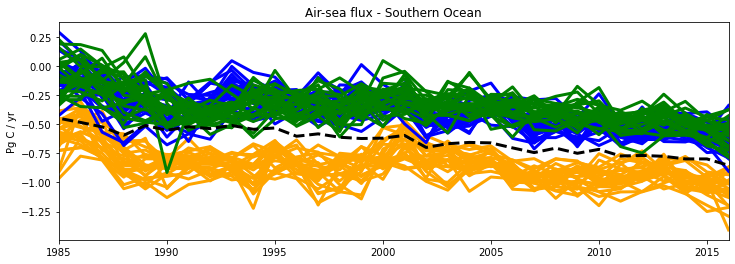

In [94]:
fig = plt.subplots(1,1,figsize=(12,4))


plt.plot(range(1983,2017),annual_fluxes_recon_SO_CESM.mean(["wind", "ensemble"])/(1e15),linewidth=3, label='recon CESM', color='orange')
plt.plot(range(1983,2017),annual_fluxes_recon_SO_CanESM2.mean(["wind", "ensemble"])/(1e15),linewidth=3, label='recon CanESM', color='blue')
plt.plot(range(1983,2017),annual_fluxes_recon_SO_GFDL.mean(["wind", "ensemble"])/(1e15),linewidth=3, label='recon GFDL', color='green')
plt.plot(range(1983,2017),flux_truth_all_SO_timeline/(1e15),linewidth=3, label='testbed truth mean', color='black', linestyle='--')


# plt.grid(True)
plt.title(f"Air-sea flux - Southern Ocean")
#plt.legend()
plt.ylabel('Pg C / yr')
#plt.ylim(-0.7,0.1)
plt.xlim(1985,2016)
#plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left');


#fig.savefig("/home/theimdal/fluxes.jpg",dpi=300)